In [1]:
#https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

In [2]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip -o -d ./

--2021-06-04 14:27:20--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.226.50.24, 13.226.50.98, 13.226.50.63, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.226.50.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip.3’

data.zip.3          100%[===================>]   2.75M  --.-KB/s    in 0.1s    

2021-06-04 14:27:20 (21.5 MB/s) - ‘data.zip.3’ saved [2882130/2882130]

Archive:  data.zip
caution: filename not matched:  -o


In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import torch
import unicodedata
import string
import random
import numpy as np
import time
import math


torch.manual_seed(4)
np.random.seed(4)
random.seed(4)

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines and category_lines_val dictionary, a list of lines per category
category_lines = {}
category_lines_val = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    random.shuffle(lines)
    eighty_five_pct = int(.85 * len(lines))
    category_lines[category] = lines[:eighty_five_pct]
    category_lines_val[category] = lines[eighty_five_pct:]

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(DEVICE)

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# categories: 18 ['Scottish', 'Czech', 'Greek', 'Italian', 'Korean', 'Chinese', 'Spanish', 'Portuguese', 'English', 'German', 'Vietnamese', 'Russian', 'Polish', 'Arabic', 'Irish', 'Japanese', 'French', 'Dutch']
O'Neal
cpu


In [35]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=True):
        super(RNN, self).__init__()

        self.drop_out = dropout
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)

        if self.drop_out:
          self.dropout = nn.Dropout(0.1)

        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        
        if self.drop_out:
          output = self.dropout(output)
          
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [36]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [37]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [38]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [39]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def test_validation():
  total_loss = 0
  total_samples = 0

  with torch.no_grad():
    for cat in category_lines_val:
      for sample in category_lines_val[cat]:

        loss = 0
        category_tensor = categoryTensor(cat)
        input_line_tensor = inputTensor(sample)
        target_line_tensor = targetTensor(sample)
        target_line_tensor.unsqueeze_(-1)
        hidden = rnn.initHidden()

        for i in range(input_line_tensor.size(0)):
          output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
          l = criterion(output, target_line_tensor[i])
          loss += l      

        total_loss += (loss.item() / input_line_tensor.size(0)) 
        total_samples += 1
  
  return total_loss / total_samples


def train(category_tensor, input_line_tensor, target_line_tensor, weight_decay = 0):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
        p.data.add_(p.data, alpha=-weight_decay)

    return output, loss.item() / input_line_tensor.size(0)

In [54]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


def plot_loss(n_iters, history):
  plt.figure()
  lal = len(history)
  plt.plot([i * n_iters / lal  for i in range(lal)], history)

def plot_and_train(dropout=True, l2=False):
  if l2:
    dropout = False
  
  l2_optimal_weight = 1e-5

  rnn = RNN(n_letters, 128, n_letters, dropout=dropout)

  n_iters = 100000
  print_every = 5000
  plot_every = 50
  all_losses = []

  start = time.time()

  for iter in range(1, n_iters + 1):
      output, loss = train(*randomTrainingExample(), weight_decay=l2_optimal_weight)

      if iter % print_every == 0:
          print('Time: %s Progress: (%d %d%%) Loss: %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))
          val_loss = test_validation()
          all_losses.append(val_loss)
          print(f'Validation loss: {val_loss}\n')

  plot_loss(n_iters, all_losses)
  return rnn

In [ ]:
rnn = plot_and_train()

Time: 0m 13s Progress: (5000 5%) Loss: 2.5955
Validation loss: 2.540409423580842



Time: 0m 13s Progress: (5000 25%) Loss: 2.4001
Validation loss: 2.5789086166830146

Time: 0m 30s Progress: (10000 50%) Loss: 2.5777
Validation loss: 2.5666429624155733

Time: 0m 47s Progress: (15000 75%) Loss: 2.4861
Validation loss: 2.5712892000868

Time: 1m 4s Progress: (20000 100%) Loss: 2.2339
Validation loss: 2.5427594114556045



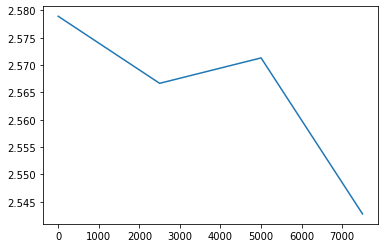

In [48]:
plot_and_train(dropout=False)

Time: 0m 13s Progress: (5000 25%) Loss: 2.4176
Validation loss: 2.5591960368389888

Time: 0m 30s Progress: (10000 50%) Loss: 3.5373
Validation loss: 2.544270695872497

Time: 0m 47s Progress: (15000 75%) Loss: 2.3743
Validation loss: 2.5366601817634917

Time: 1m 4s Progress: (20000 100%) Loss: 1.9654
Validation loss: 2.543472065304242



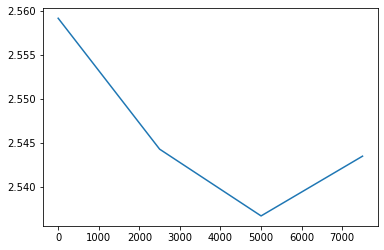

In [49]:
plot_and_train(l2=True)

In [53]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
langs = ['English', 'Portuguese', 'Russian', 'Greek', 'Chinese', 'Dutch']

out = [print(f"Sample name in {lang}: {sample(lang, 'E')} \n") for lang in langs]

Sample name in English: Eanter 

Sample name in Portuguese: Eaner 

Sample name in Russian: Eanton 

Sample name in Greek: Earousosos 

Sample name in Chinese: Eon 

Sample name in Dutch: Earen 

